# Model

## Requirements

- import libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import optuna

- constant variables

In [2]:
DESKTOP_DIR = "C:/Users/mapmxj/Desktop/"

- functions

In [3]:
from general_functions import data_validation, data_profiling, data_exploration
from ml_classification import *

## EDA

### Load Data

In [4]:
filename = "..\\data\\train.csv"
train_df = pd.read_csv(filename)

filename = "..\\data\\test.csv"
test_df = pd.read_csv(filename)
test_df['Exited'] = 0
test_id = test_df['id'].values
train_df.head()

,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,0,15674932,Okwudilichukwu,668,France,Male,33.0,3,0.00,2,1.0,0.0,181449.97,0
1,1,15749177,Okwudiliolisa,627,France,Male,33.0,1,0.00,2,1.0,1.0,49503.50,0
2,2,15694510,Hsueh,678,France,Male,40.0,10,0.00,2,1.0,0.0,184866.69,0
3,3,15741417,Kao,581,France,Male,34.0,2,148882.54,1,1.0,1.0,84560.88,0
4,4,15766172,Chiemenam,716,Spain,Male,33.0,5,0.00,2,1.0,1.0,15068.83,0


- check data type

In [5]:
data_schema = data_validation.get_data_schema(train_df)
data_schema

{'id': 'int64',
 'CustomerId': 'int64',
 'Surname': 'object',
 'CreditScore': 'int64',
 'Geography': 'object',
 'Gender': 'object',
 'Age': 'float64',
 'Tenure': 'int64',
 'Balance': 'float64',
 'NumOfProducts': 'int64',
 'HasCrCard': 'float64',
 'IsActiveMember': 'float64',
 'EstimatedSalary': 'float64',
 'Exited': 'int64'}

- convert data types

In [6]:
data_schema['HasCrCard'] = 'int'
data_schema['IsActiveMember'] = 'int'

for key, value in data_schema.items():
    train_df[key] = train_df[key].values.astype(value)
    test_df[key] = test_df[key].values.astype(value)

### Data Profile

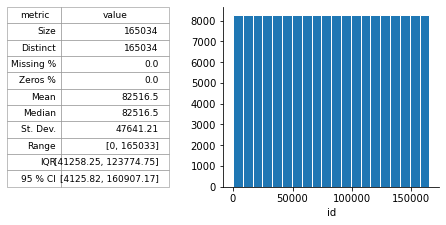

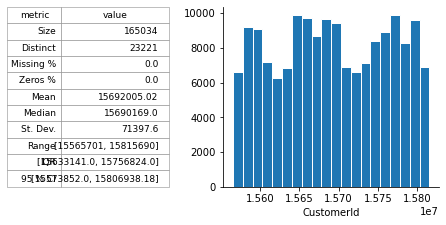

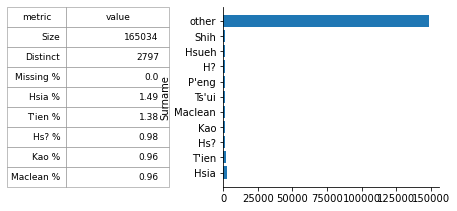

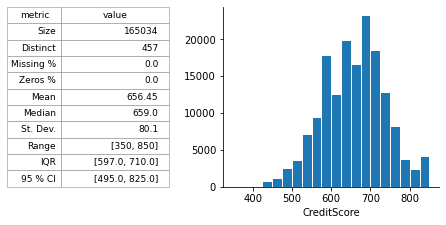

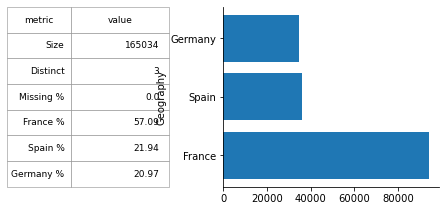

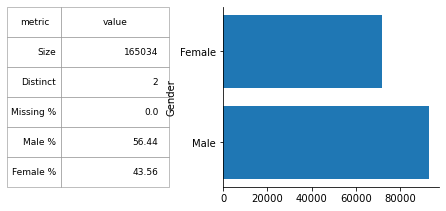

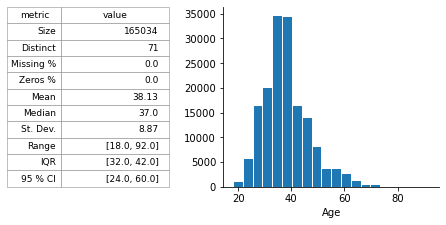

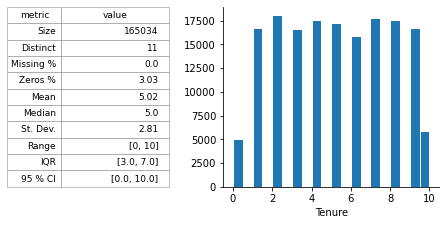

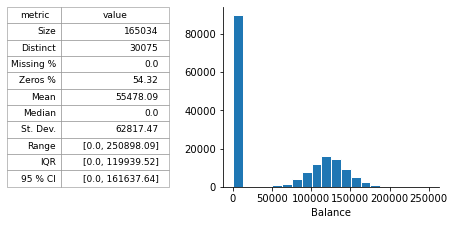

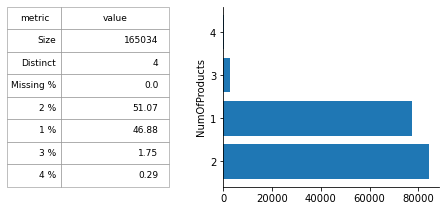

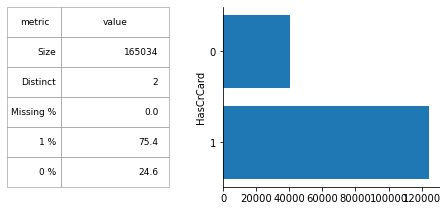

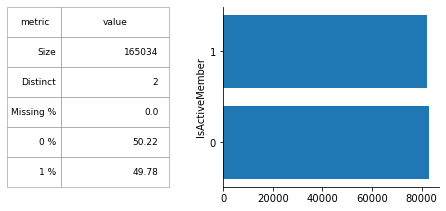

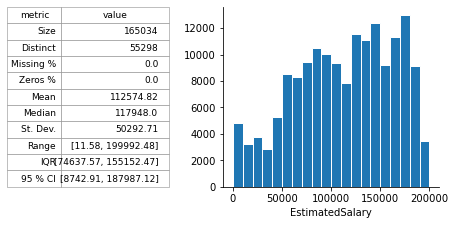

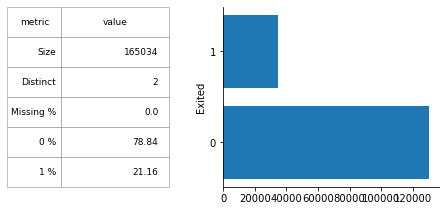

In [7]:
data_profiling.summarize_data(train_df)

### XY correlations

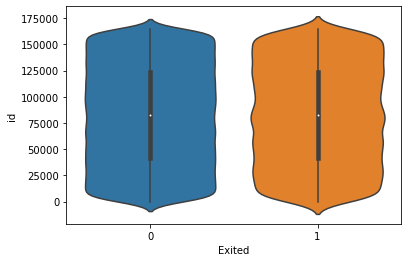

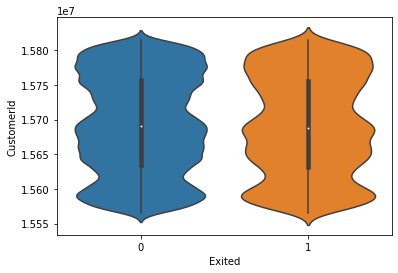

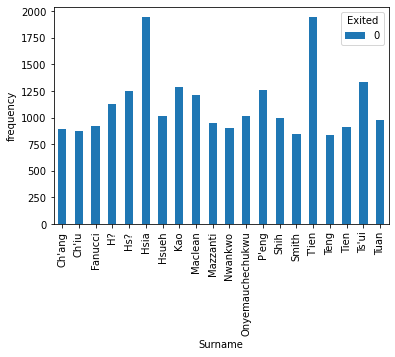

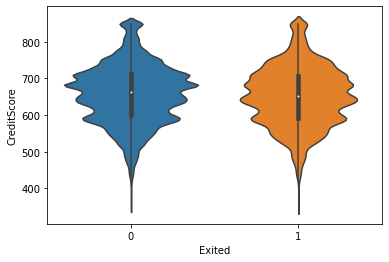

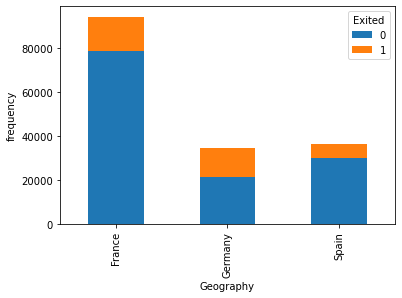

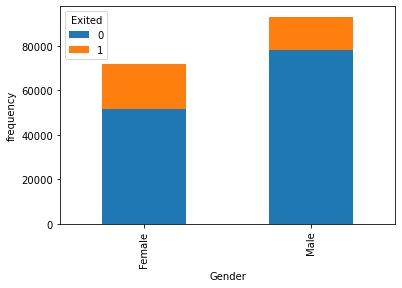

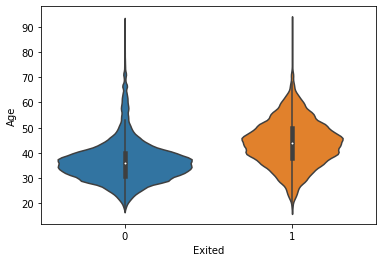

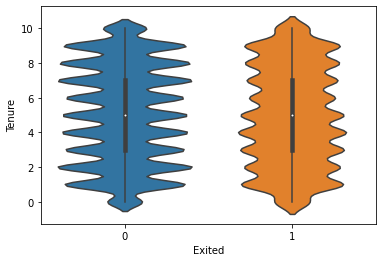

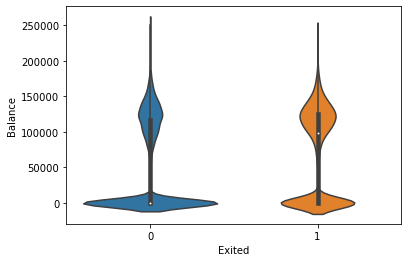

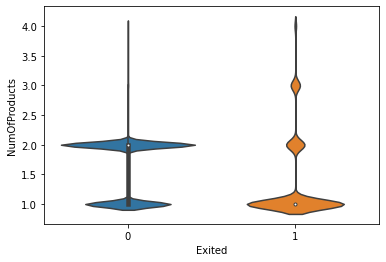

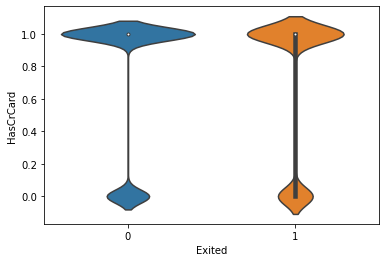

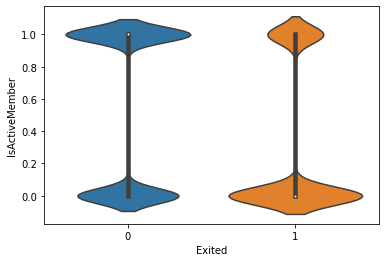

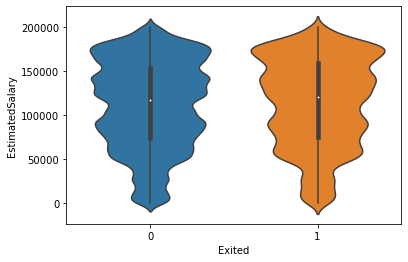

In [8]:
import seaborn as sns


def xy_violinplot(df: pd.DataFrame, target: str, feature: str) -> None:
    _, ax = plt.subplots()
    sns.violinplot(data=df, x=target, y=feature, ax=ax, orient="v")
    plt.show()


def xy_barplot(
    df: pd.DataFrame, target: str, features: list[str], top_k=20, percentage=False
):
    by = features + [target]
    sum_df = df.groupby(by).size().nlargest(top_k).unstack()

    _, ax = plt.subplots()
    if percentage:
        sum_df.apply(lambda x: x / x.sum(), axis=1).plot(
            kind="bar", stacked=True, ax=ax
        )
        ax.set_ylabel("percentage")
    else:
        sum_df.plot(kind="bar", stacked=True, ax=ax)
        ax.set_ylabel("frequency")

    plt.show()


def xy_scatterplot(df: pd.DataFrame, x_col: str, y_col: str, color=None) -> None:

    _, ax = plt.subplots()
    sns.scatterplot(data=df, x=x_col, y=y_col, hue=color)

    ax.set_xlabel(x_col)
    ax.set_ylabel(y_col)
    plt.title("")
    plt.suptitle("")
    plt.show()


for col, dtype in data_schema.items():
    if col == "Exited":
        continue
    if dtype != "object":
        xy_violinplot(train_df, "Exited", col)
    else:
        xy_barplot(train_df, "Exited", [col])

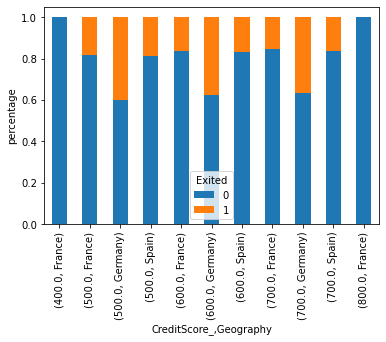

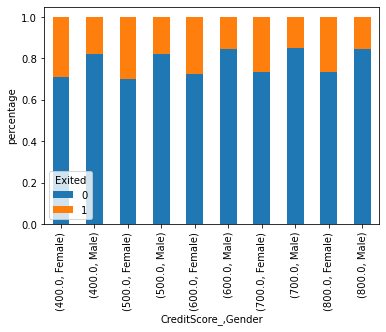

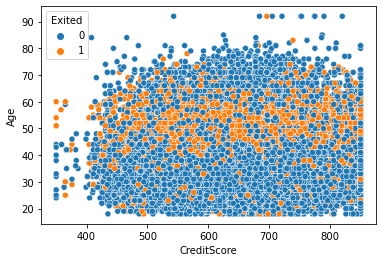

c:\ProgramData\Anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


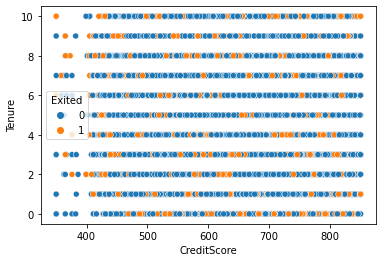

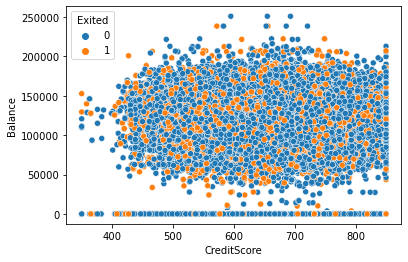

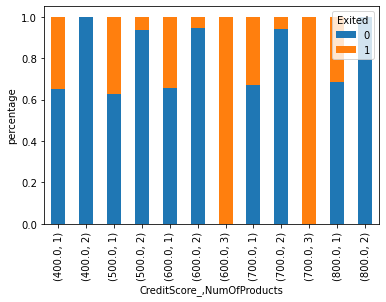

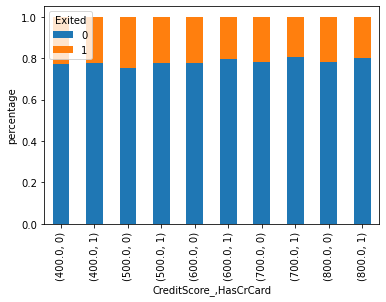

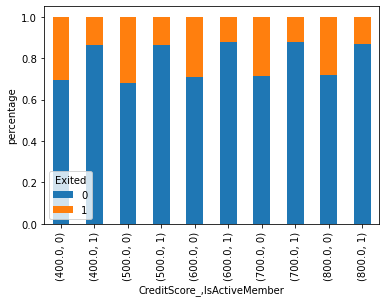

c:\ProgramData\Anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


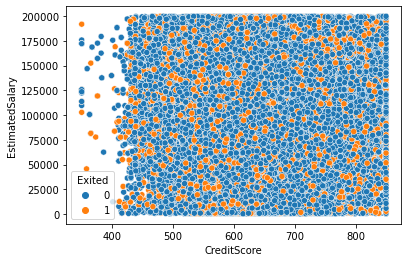

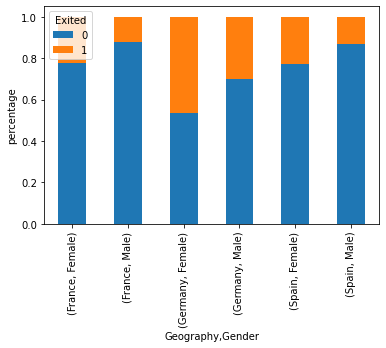

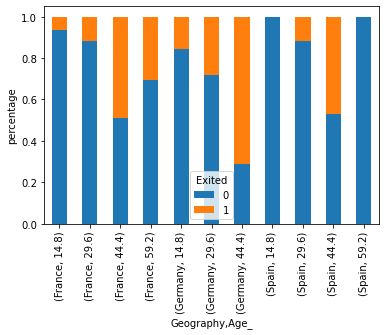

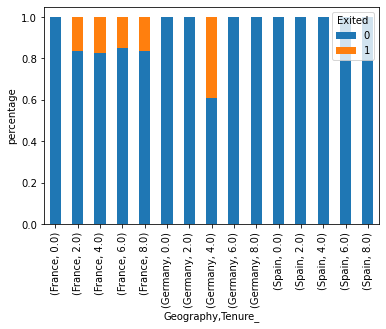

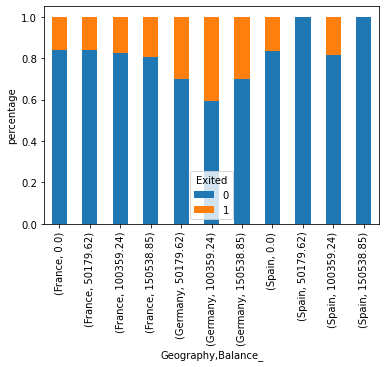

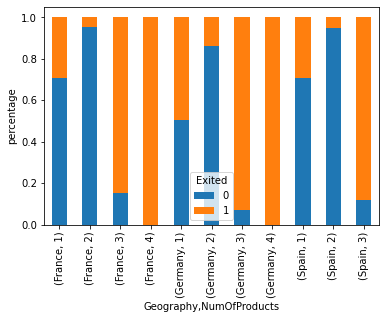

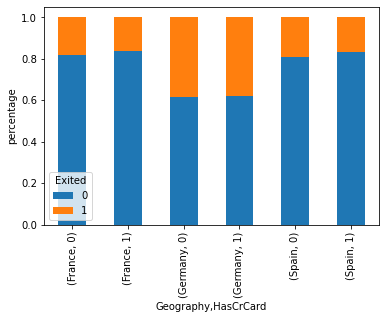

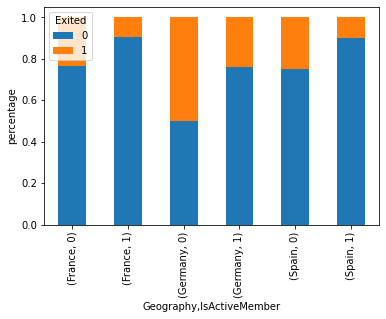

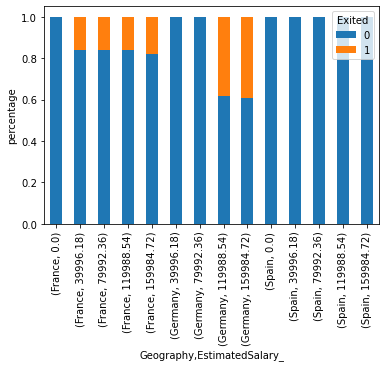

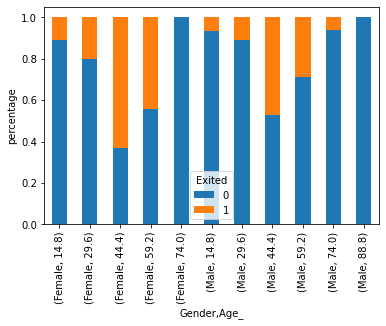

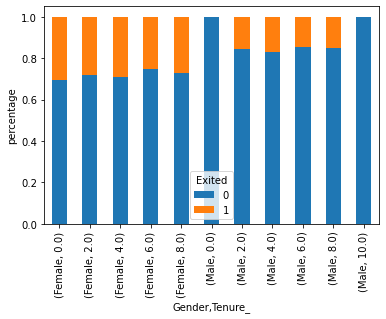

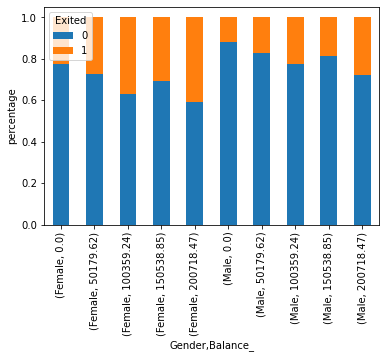

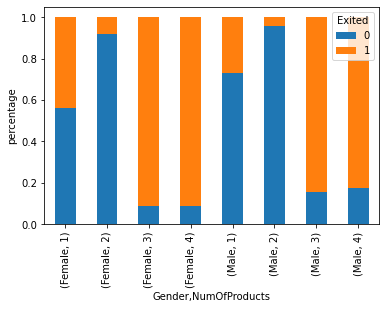

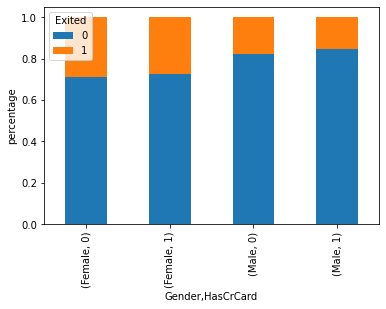

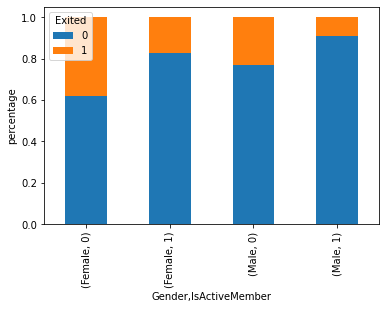

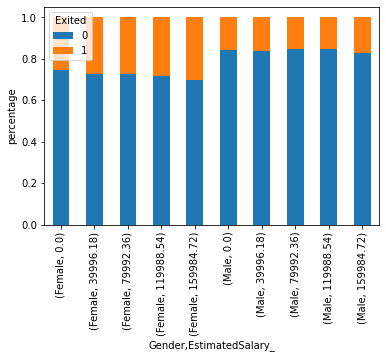

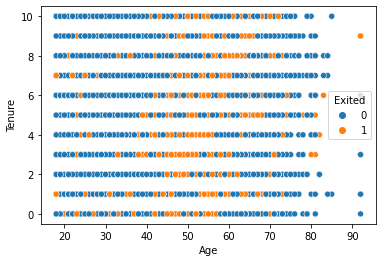

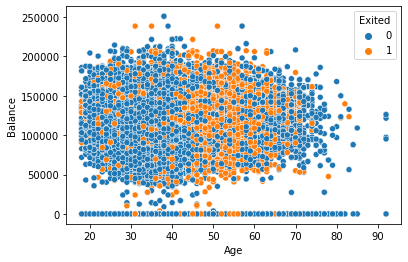

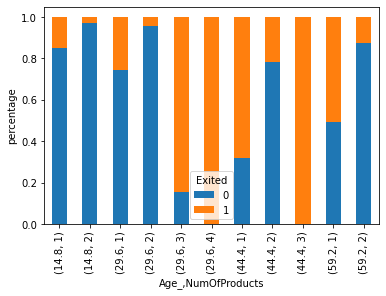

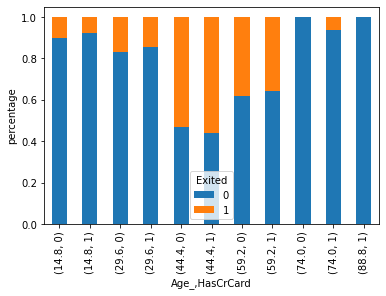

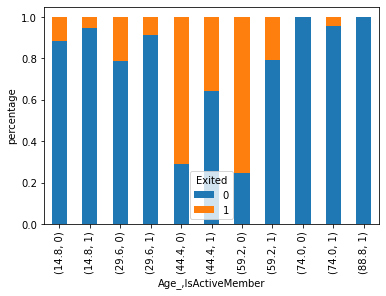

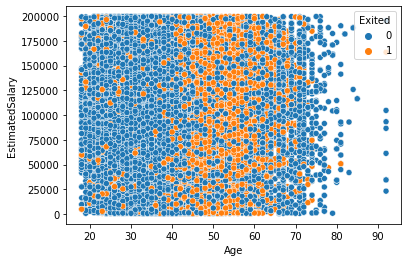

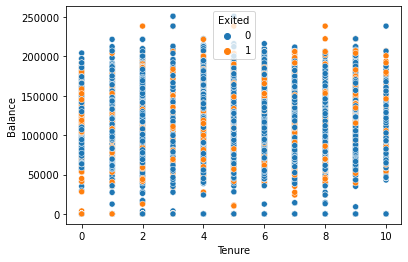

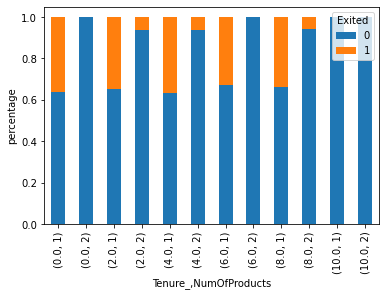

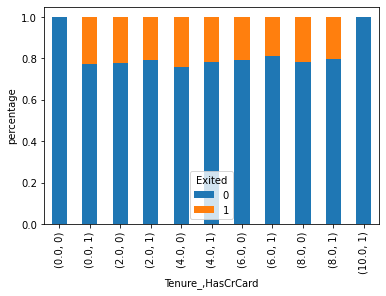

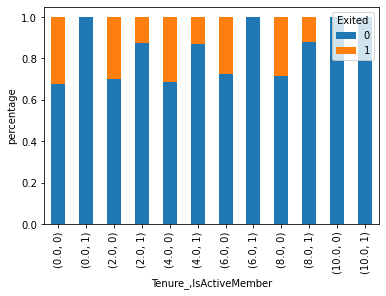

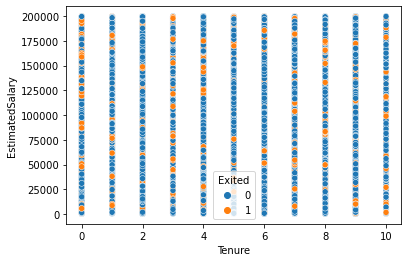

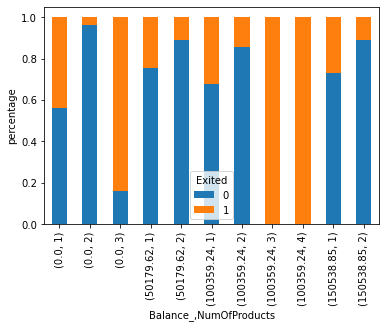

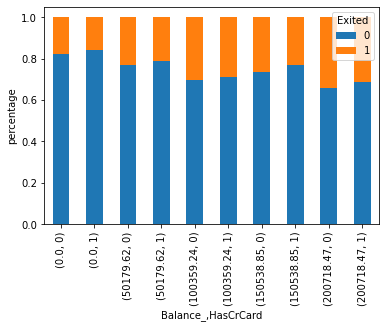

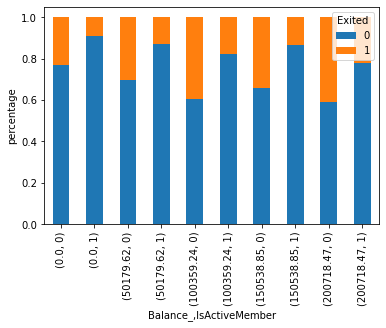

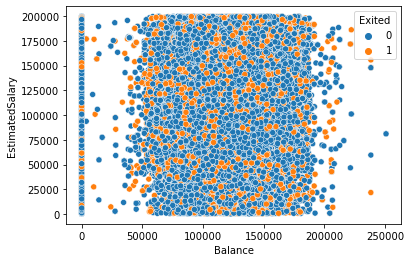

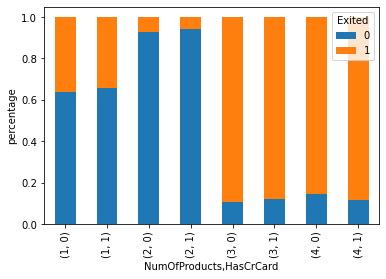

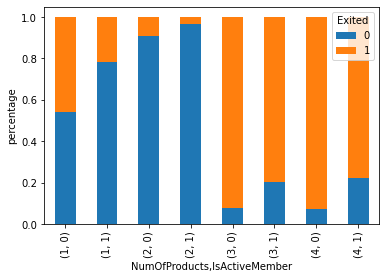

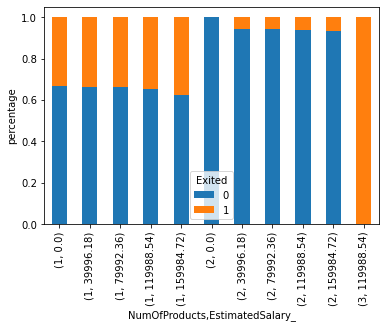

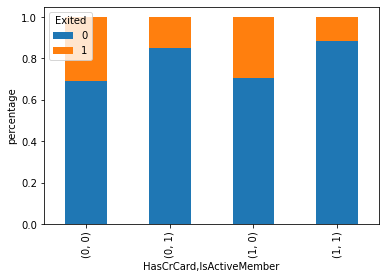

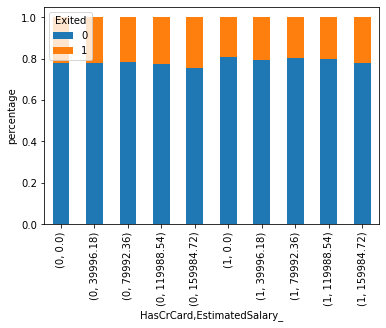

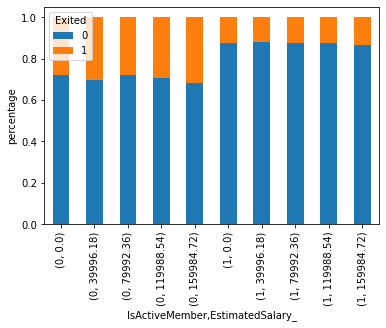

In [9]:
target = "Exited"
cols = list(data_schema.keys())[3:-1]
copy_df = train_df.copy()
for i, c1 in enumerate(cols):
    for c2 in cols[i + 1 :]:
        if (
            data_schema[c1] == "object"
            or data_schema[c2] == "object"
            or len(copy_df[c1].unique()) <= 5
            or len(copy_df[c2].unique()) <= 5
        ):
            c1_copy = c1
            c2_copy = c2
            if data_schema[c1] != "object" and len(copy_df[c1].unique()) > 5:
                v = copy_df[c1].values
                delta = (v.max() - v.min()) / 5
                v = np.round(delta * (v // delta), 2)
                c1_copy = c1 + "_"
                copy_df[c1_copy] = v
            if data_schema[c2] != "object" and len(copy_df[c2].unique()) > 5:
                v = copy_df[c2].values
                delta = (v.max() - v.min()) / 5
                v = np.round(delta * (v // delta), 2)
                c2_copy = c2 + "_"
                copy_df[c2_copy] = v

            xy_barplot(copy_df, "Exited", [c1_copy, c2_copy], percentage=True)
        else:
            xy_scatterplot(copy_df, c1, c2, "Exited")

### Feature Engineering

In [7]:
train_df.drop(['id', 'CustomerId'], axis=1, inplace=True)
test_df.drop(['id', 'CustomerId'], axis=1, inplace=True)

- Customer names

In [8]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD

vectorizer = TfidfVectorizer(max_features=1000)
surname_vec = vectorizer.fit_transform(train_df['Surname'])
train_df.drop(['Surname'], axis=1, inplace=True)

top_n = 20
svd = TruncatedSVD(top_n)
cols = ['tfid_{}'.format(i) for i in range(1,top_n+1)]
surname_pca = svd.fit_transform(surname_vec)

surname_df = pd.DataFrame(surname_pca, 
                          columns = cols)

surname_df_test = pd.DataFrame(svd.transform(vectorizer.transform(test_df['Surname'])), 
                          columns = cols)
test_df.drop(['Surname'], axis=1, inplace=True)

surname_df

,tfid_1,tfid_2,tfid_3,tfid_4,tfid_5,tfid_6,tfid_7,tfid_8,tfid_9,tfid_10,tfid_11,tfid_12,tfid_13,tfid_14,tfid_15,tfid_16,tfid_17,tfid_18,tfid_19,tfid_20
0,2.048121e-08,-2.619387e-07,-7.046925e-07,5.239217e-06,-6.429548e-06,1.014056e-06,2.036096e-06,-1.351542e-05,4.238907e-05,4.663795e-07,-2.261788e-05,-3.116065e-05,-7.534836e-05,-2.926475e-05,-7.036597e-05,4.244664e-05,1.199527e-05,-2.359622e-04,-4.583682e-05,-9.852000e-05
1,3.256658e-07,3.309626e-07,-8.971949e-07,2.296765e-06,4.406383e-07,-2.287069e-05,-5.004963e-06,2.494547e-06,-9.498088e-05,3.049618e-05,1.042778e-05,5.457065e-06,3.423951e-05,7.072433e-05,3.189158e-05,3.838580e-05,-1.208679e-04,-2.149587e-05,1.510124e-05,-4.369179e-04
2,3.429537e-06,-4.587906e-05,5.453488e-05,1.369815e-04,-3.097118e-05,3.424498e-04,6.063284e-04,9.468106e-04,-4.166549e-02,9.979375e-01,2.389807e-02,-3.590563e-03,1.186268e-02,-3.838792e-03,-7.448421e-04,-1.586453e-03,-4.229179e-03,-4.989319e-03,-1.140031e-02,6.066219e-04
3,5.071274e-06,-1.459957e-05,1.147283e-05,9.236191e-05,-3.043545e-05,-7.404486e-04,9.712969e-01,-2.375430e-01,1.420245e-03,-2.510205e-04,-1.184731e-03,-5.580756e-04,-1.653528e-05,5.187755e-04,-1.805974e-04,3.586959e-04,1.569808e-04,8.046699e-04,-4.269957e-04,2.122251e-03
4,-1.104268e-07,4.601834e-07,-2.441348e-07,-4.742789e-07,-3.733719e-07,5.112718e-06,-1.700422e-06,5.314806e-06,-8.615838e-06,2.153416e-05,-7.455773e-07,3.013132e-05,4.705127e-05,2.234664e-05,4.042424e-05,-3.667026e-05,-5.756216e-05,-1.221813e-05,3.127112e-05,-1.950324e-05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
165029,6.733784e-12,-1.647042e-10,2.951972e-10,-1.767675e-10,-5.237179e-10,-7.528962e-10,2.019321e-09,1.966639e-09,-4.419044e-09,-5.181617e-10,1.618497e-09,-1.333955e-09,-1.442671e-09,-3.484938e-09,6.570750e-10,2.111711e-09,3.102600e-09,6.036067e-09,9.542930e-09,7.196950e-09
165030,-7.702030e-08,1.591430e-06,-5.921068e-08,1.994452e-06,8.425380e-06,-6.297238e-06,-8.170313e-06,-3.017477e-05,1.152241e-04,1.307201e-05,-9.082700e-05,1.590653e-05,2.713622e-06,1.478406e-05,-9.452813e-05,1.096259e-04,-8.377821e-05,-2.888347e-04,-9.569530e-05,4.614688e-06
165031,1.838536e-06,9.999991e-01,-3.277925e-04,-2.711200e-05,1.577196e-05,3.169574e-05,6.083291e-06,-1.327666e-05,3.800296e-05,2.480590e-05,5.449441e-06,-7.251111e-06,5.852053e-05,2.724614e-05,1.895531e-05,7.245377e-06,-2.273694e-05,2.164341e-05,-5.751816e-05,1.090467e-04
165032,7.204290e-05,-4.809358e-05,1.329049e-04,5.575911e-04,-8.536451e-04,-5.530863e-03,-9.384487e-04,1.450186e-03,-3.034135e-02,-3.789632e-03,2.344908e-02,1.260828e-02,4.676333e-02,-1.093563e-02,-9.331064e-03,6.401787e-03,-2.691469e-04,5.754072e-02,3.351027e-02,-3.149711e-01


- Categorizing Credit Score

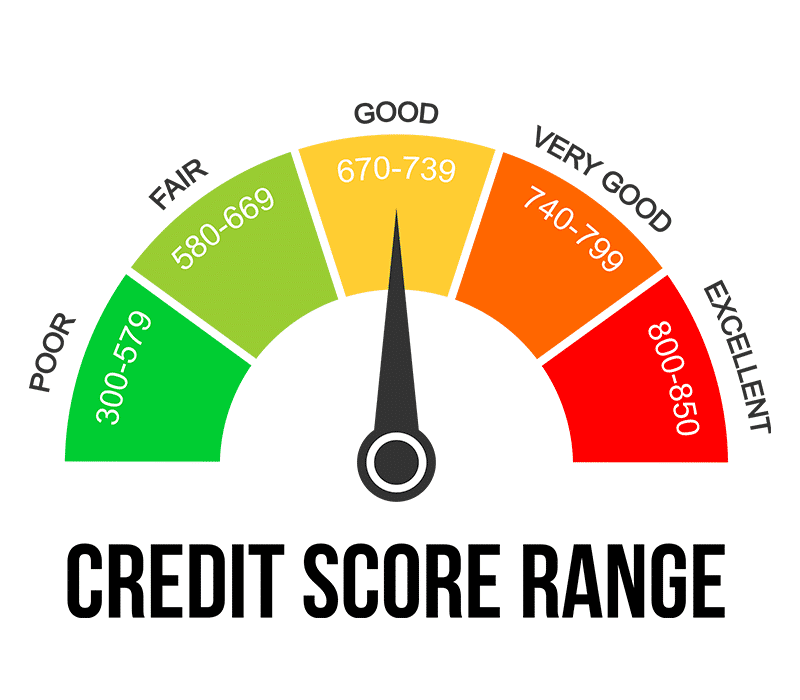

In [9]:
credit_range = {
    'Poor Credit': [300, 579],
    'Fair Credit': [580, 669],
    'Good Credit': [670, 739],
    'Very Good Credit': [740, 799],
    'Excellent Credit': [800, 850],
}
for key, val in credit_range.items():
    group = 1*((train_df['CreditScore'].values>=val[0]) &
                 (train_df['CreditScore'].values<=val[1]))
    no_col = train_df.shape[1]-1
    train_df.insert(no_col, key, group)

    group = 1*((test_df['CreditScore'].values>=val[0]) &
                 (test_df['CreditScore'].values<=val[1]))
    no_col = test_df.shape[1]-1
    test_df.insert(no_col, key, group)

- Zero Balance

In [10]:
zeroBalance = 1*(train_df['Balance']==0)

no_col = train_df.shape[1]-1
train_df.insert(no_col, 'zeroBalance', zeroBalance)

zeroBalance = 1*(test_df['Balance']==0)
test_df.insert(no_col, 'zeroBalance', zeroBalance)

- Age buckets

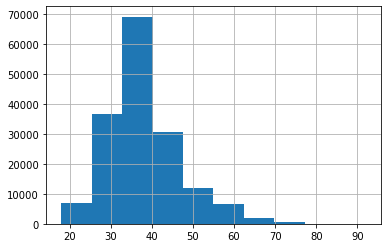

In [11]:
train_df['Age'].hist()
age_range = {
    '20-25': [20, 25],
    '25-35': [25, 35],
    '35-65': [35, 65],
    '+65': [65, 100]
}
for key, val in age_range.items():
    group = 1*((train_df['Age'].values>=val[0]) &
                 (train_df['Age'].values<=val[1]))
    no_col = train_df.shape[1]-1
    train_df.insert(no_col, key, group)

    group = 1*((test_df['Age'].values>=val[0]) &
                 (test_df['Age'].values<=val[1]))
    test_df.insert(no_col, key, group)

- Senior and Fresh users

In [12]:
new_users = (train_df['Tenure']==0)*1
no_col = train_df.shape[1]-1
train_df.insert(no_col, 'New User', new_users)

new_users = (test_df['Tenure']==0)*1
test_df.insert(no_col, 'New User', new_users)

old_users = (train_df['Tenure']==10)*1
no_col = train_df.shape[1]-1
train_df.insert(no_col, 'Old User', old_users)

old_users = (test_df['Tenure']==10)*1
test_df.insert(no_col, 'Old User', old_users)

- Salary Buckets

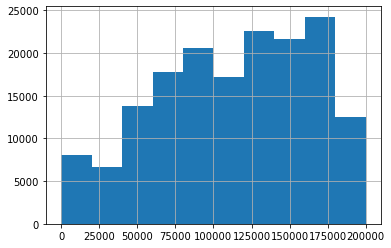

In [13]:
train_df['EstimatedSalary'].hist()
salary_range = {
    '<20k': [0, 20000],
    '20k-50k': [20000, 50000],
    '50k-100k': [50000, 100000],
    '100k-150k': [100000, 150000],
    '150k+': [150000, 250000]

}
for key, val in salary_range.items():
    group = 1*((train_df['EstimatedSalary'].values>=val[0]) &
                 (train_df['EstimatedSalary'].values<=val[1]))
    no_col = train_df.shape[1]-1
    train_df.insert(no_col, key, group)

    group = 1*((test_df['EstimatedSalary'].values>=val[0]) &
                 (test_df['EstimatedSalary'].values<=val[1]))
    test_df.insert(no_col, key, group)

- encoder:
    - Geography
    - Gender
    - names

In [14]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

x = train_df.iloc[:,:-1].values
y = train_df.iloc[:,-1].values
columns = list(train_df.columns)[:-1]

x_test = test_df.iloc[:,:-1].values

gender_en = LabelEncoder()
col_id = columns.index('Gender')
x[:,col_id] = gender_en.fit_transform(x[:,col_id])
x_test[:,col_id] = gender_en.transform(x_test[:,col_id])


encoded_features = ['Geography','NumOfProducts']

one_hat_columns = [columns.index(f) for f in encoded_features]
one_hat_encoder = ColumnTransformer(
        transformers= [
            ("one_hat_en", 
            OneHotEncoder(handle_unknown='ignore', sparse=False),
            one_hat_columns)
        ],
        remainder = 'passthrough'
        )
encoded_x = np.array(one_hat_encoder.fit_transform(x))
x_test = np.array(one_hat_encoder.transform(x_test))

features =[]

for name in one_hat_encoder.get_feature_names_out():
    if 'x' not in name:
        continue
    f = name.split('x')[1]
    if '_' in f:
        n,v = f.split('_')
        n = int(n)
        f = "{}={}".format(columns[n],v)
    else:
        n = int(f)
        f = columns[n]
    features.append(f)
    print("{} -> {}".format(name, f))
ALL_FEATURES = features

ALL_FEATURES += list(surname_df.columns)
encoded_x = np.column_stack((encoded_x,surname_df.values))
x_test = np.column_stack((x_test,surname_df_test.values))

one_hat_en__x1_France -> Geography=France
one_hat_en__x1_Germany -> Geography=Germany
one_hat_en__x1_Spain -> Geography=Spain
one_hat_en__x6_1 -> NumOfProducts=1
one_hat_en__x6_2 -> NumOfProducts=2
one_hat_en__x6_3 -> NumOfProducts=3
one_hat_en__x6_4 -> NumOfProducts=4
remainder__x0 -> CreditScore
remainder__x2 -> Gender
remainder__x3 -> Age
remainder__x4 -> Tenure
remainder__x5 -> Balance
remainder__x7 -> HasCrCard
remainder__x8 -> IsActiveMember
remainder__x9 -> EstimatedSalary
remainder__x10 -> Poor Credit
remainder__x11 -> Fair Credit
remainder__x12 -> Good Credit
remainder__x13 -> Very Good Credit
remainder__x14 -> Excellent Credit
remainder__x15 -> zeroBalance
remainder__x16 -> 20-25
remainder__x17 -> 25-35
remainder__x18 -> 35-65
remainder__x19 -> +65
remainder__x20 -> New User
remainder__x21 -> Old User
remainder__x22 -> <20k
remainder__x23 -> 20k-50k
remainder__x24 -> 50k-100k
remainder__x25 -> 100k-150k
remainder__x26 -> 150k+


In [15]:
sc = MinMaxScaler()
x_scaled = sc.fit_transform(encoded_x)
x_test = sc.fit_transform(x_test)

x_copy = x_scaled.copy()
feature_copy = ALL_FEATURES.copy()
cols = [
 ['*', 'HasCrCard', 'IsActiveMember'],
 ['/', 'EstimatedSalary','Tenure'],
 ['*', 'NumOfProducts=1','Tenure'],
 ['*', 'zeroBalance','20-25'],
 ['*', 'Geography=Germany','Gender'],
 ['/', 'Geography=Germany','Gender'],
 ['*', 'Geography=Germany','IsActiveMember'],
 ['*', 'Geography=Germany','EstimatedSalary'],
 ['*', '20-25','IsActiveMember'],
 ['*', '35-65','Gender'],
 ['*', 'NumOfProducts=1','IsActiveMember'],

]
for s, f1, f2 in cols:
        i = ALL_FEATURES.index(f1)
        j = ALL_FEATURES.index(f2)
        if s=='*':
                a = x_copy[:, i] * x_copy[:, j]
                b = x_test[:, i] * x_test[:, j]
                
        else:
                a = x_copy[:, i] / (0.0001+x_copy[:, j])
                b = x_test[:, i] / (0.0001+x_test[:, j])

        feature_copy.append("{}{}{}".format(f1, s, f2))
        x_copy = np.column_stack((x_copy, a))
        x_test = np.column_stack((x_test, b))


feature_copy.append("1/Balance")
i = ALL_FEATURES.index('Balance')
a = 1/(0.00001+x_copy[:, i])
x_copy = np.column_stack((x_copy, a))

b = 1/(0.00001+x_test[:, i])
x_test = np.column_stack((x_test, b))

print(x_copy.shape, x_test.shape)


(165034, 64) (110023, 64)


- Feature Correlations

Top 20 highly correlated features:
                                     Row             Column     value
1973                          1/Balance        zeroBalance  1.000000
1964                          1/Balance            Balance  0.963093
201                         zeroBalance            Balance  0.963088
9                       NumOfProducts=2    NumOfProducts=1  0.959920
1403             EstimatedSalary/Tenure           New User  0.909743
1712  Geography=Germany*EstimatedSalary  Geography=Germany  0.896420
275                               35-65              25-35  0.796458
1434             NumOfProducts=1*Tenure    NumOfProducts=1  0.789789
1339           HasCrCard*IsActiveMember     IsActiveMember  0.771047
1435             NumOfProducts=1*Tenure    NumOfProducts=2  0.758134
1506                  zeroBalance*20-25              20-25  0.736052
479                               150k+    EstimatedSalary  0.732009
1791               20-25*IsActiveMember              20-25  0.71582

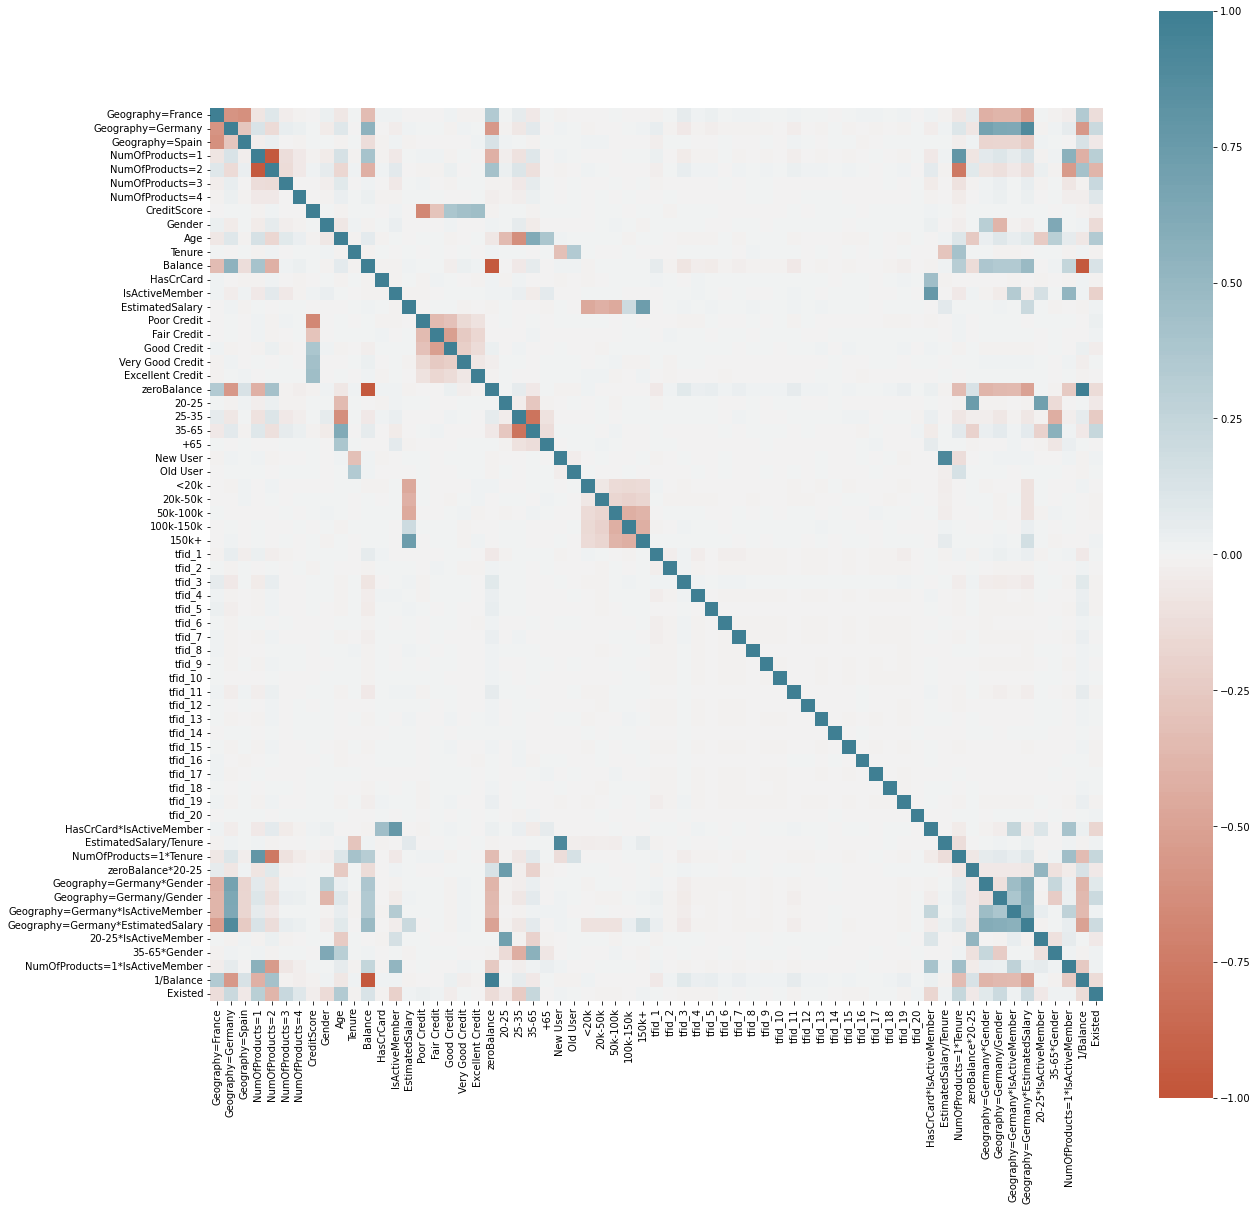

In [16]:
import seaborn as sns

copy_df = pd.DataFrame(x_copy.astype('float'),columns=feature_copy)
copy_df['Existed'] = y

corr = copy_df.corr().fillna(0)
fig,ax = plt.subplots(figsize=(20,20))
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)

is_lower_triangle = 1- np.triu(np.ones(corr.shape)).astype('bool')
df = corr.where(is_lower_triangle==1)
df = df.stack().reset_index()
df.columns = ['Row','Column','value']

df['value'] = np.abs(df['value'].values)
df.sort_values(by='value', ascending=False, inplace=True)

print("Top 20 highly correlated features:\n",
    df.head(20))

print("\nTop 20 features correlated to Y :\n",
    df.query('`Row`=="Existed"').head(20))

- Drop Correlated features

In [17]:
y_col = 'Exited'
threshold = 0.90

correlated_feautres = set()
seen_features = set()
for i, row in df.iterrows():
    if row['Row']== y_col or row['Column'] == y_col:
        continue

    if row['value']<threshold or \
        row['Row']== row['Column']:
        continue
    if row['Row'] in seen_features or\
        row['Column'] in seen_features:
         continue
    seen_features.add(row['Row'])
    seen_features.add(row['Column'])
    if  row['Row'] not in correlated_feautres:
        correlated_feautres.add(row['Column'])

is_correlated = []

for i,f in enumerate(feature_copy):
    if f not in correlated_feautres:
        is_correlated.append(i)
feature_copy = list(np.array(feature_copy)[is_correlated])
x_copy = x_copy[:,is_correlated]
x_test = x_test[:,is_correlated]
feature_copy

['Geography=France',
 'Geography=Germany',
 'Geography=Spain',
 'NumOfProducts=2',
 'NumOfProducts=3',
 'NumOfProducts=4',
 'CreditScore',
 'Gender',
 'Age',
 'Tenure',
 'Balance',
 'HasCrCard',
 'IsActiveMember',
 'EstimatedSalary',
 'Poor Credit',
 'Fair Credit',
 'Good Credit',
 'Very Good Credit',
 'Excellent Credit',
 '20-25',
 '25-35',
 '35-65',
 '+65',
 'Old User',
 '<20k',
 '20k-50k',
 '50k-100k',
 '100k-150k',
 '150k+',
 'tfid_1',
 'tfid_2',
 'tfid_3',
 'tfid_4',
 'tfid_5',
 'tfid_6',
 'tfid_7',
 'tfid_8',
 'tfid_9',
 'tfid_10',
 'tfid_11',
 'tfid_12',
 'tfid_13',
 'tfid_14',
 'tfid_15',
 'tfid_16',
 'tfid_17',
 'tfid_18',
 'tfid_19',
 'tfid_20',
 'HasCrCard*IsActiveMember',
 'EstimatedSalary/Tenure',
 'NumOfProducts=1*Tenure',
 'zeroBalance*20-25',
 'Geography=Germany*Gender',
 'Geography=Germany/Gender',
 'Geography=Germany*IsActiveMember',
 'Geography=Germany*EstimatedSalary',
 '20-25*IsActiveMember',
 '35-65*Gender',
 'NumOfProducts=1*IsActiveMember',
 '1/Balance']

- Feature Importance

TOP 30 important features
                              feature     score
3                     NumOfProducts=2  0.458975
59     NumOfProducts=1*IsActiveMember  0.159766
4                     NumOfProducts=3  0.054362
8                                 Age  0.047757
54           Geography=Germany/Gender  0.029539
21                              35-65  0.022849
12                     IsActiveMember  0.020794
1                   Geography=Germany  0.020462
7                              Gender  0.012742
49           HasCrCard*IsActiveMember  0.012458
10                            Balance  0.010859
56  Geography=Germany*EstimatedSalary  0.009222
5                     NumOfProducts=4  0.006890
51             NumOfProducts=1*Tenure  0.006182
41                            tfid_13  0.005096
46                            tfid_18  0.004352
48                            tfid_20  0.004303
20                              25-35  0.004289
44                            tfid_16  0.004044
34            

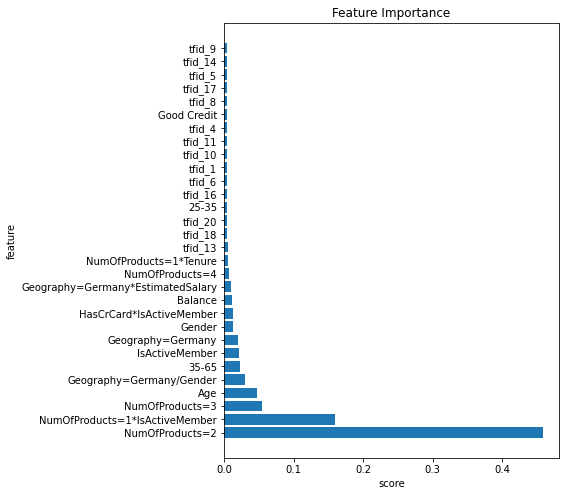

In [18]:
im_df = feature_importance(x_copy, y, feature_copy, is_classifer=True, top_k=30)

- Drop un-important features

In [19]:
unimportant_feautres= im_df.query('score < 0.002')['feature'].values

is_important = []

for i,f in enumerate(feature_copy):
    if f not in unimportant_feautres:
        is_important.append(i)
feature_copy = list(np.array(feature_copy)[is_important])
x_copy = x_copy[:,is_important]
x_test = x_test[:,is_important]

print(x_copy.shape, x_test.shape)

(165034, 51) (110023, 51)


## Model Development

(132027, 51) (33007, 51)


(array([104095.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,  27932.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

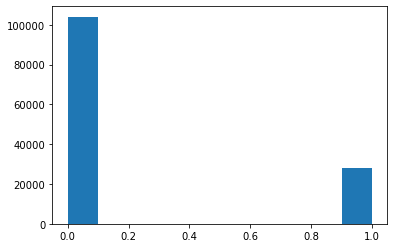

In [20]:
x_train, x_val, y_train, y_val = train_test_split(x_copy, y, test_size=0.2)
print(x_train.shape, x_val.shape)

plt.hist(y_train)

- Oversampling

(array([104095.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0., 104095.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

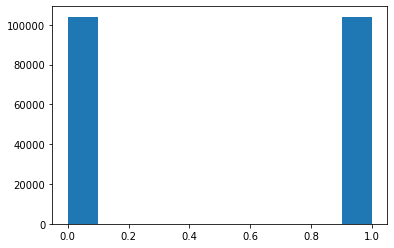

In [21]:
from imblearn.over_sampling import SMOTE

sampler = SMOTE(random_state=123, sampling_strategy=1)
x_over, y_over = sampler.fit_resample(x_train, y_train)

sample_x, _, sample_y,_ = train_test_split(
    x_over, y_over, train_size=0.05, stratify=y_over, random_state=123
)
plt.hist(y_over)

- Find best model

In [23]:
lgbm_params = {
    "n_estimators": 2000,
    "max_depth": 10,
    "learning_rate": 0.013116268994351215,
    "min_child_weight": 1.2901080704049384,
    "min_child_samples": 9,
    "subsample": 0.9703847511420041,
    "subsample_freq": 2,
    "colsample_bytree": 0.4308261070757712,
    "objective": "binary",
    "verbose": -1,
    "random_state": 123,
}

models = {
    "rf": RandomForestClassifier(random_state=123),
    "lgb": LGBMClassifier(random_state=123),
    "xgb": XGBClassifier(random_state=123),
}


best_model = compare_models(sample_x, sample_y, models)

rf	Accuracy: 0.82	AUC: 0.82	Recall: 0.82	Precision: 0.82	F1-Score: 0.82	Kappa: 0.65	MCC: 0.65	Log Loss: 0.40	Training Time: 2.04	
lgb	Accuracy: 0.87	AUC: 0.87	Recall: 0.87	Precision: 0.87	F1-Score: 0.87	Kappa: 0.75	MCC: 0.75	Log Loss: 0.30	Training Time: 0.40	
xgb	Accuracy: 0.87	AUC: 0.87	Recall: 0.87	Precision: 0.87	F1-Score: 0.87	Kappa: 0.74	MCC: 0.74	Log Loss: 0.31	Training Time: 2.33	


,Model,Accuracy,AUC,Recall,Precision,F1-Score,Kappa,MCC,Log Loss,Training Time
1,lgb,0.872993,0.872993,0.872993,0.873208,0.872975,0.745986,0.746201,0.298630,0.401255
2,xgb,0.870493,0.870493,0.870493,0.870775,0.870469,0.740986,0.741268,0.309524,2.332666
0,rf,0.824439,0.824439,0.824439,0.824763,0.824392,0.648878,0.649202,0.399369,2.043472



*******
Results for model LGBMClassifier(random_state=123):



,metrics,train,validation
0,Accuracy,0.91,0.86
1,AUC,0.91,0.78
2,Recall,0.91,0.86
3,Precision,0.91,0.86
4,F1-Score,0.91,0.86
5,Kappa,0.81,0.57
6,MCC,0.81,0.58
7,Log Loss,0.24,0.32
8,Training Time,4.06,4.06


              precision    recall  f1-score   support

           0       0.90      0.93      0.92     26095
           1       0.69      0.63      0.66      6912

    accuracy                           0.86     33007
   macro avg       0.80      0.78      0.79     33007
weighted avg       0.86      0.86      0.86     33007



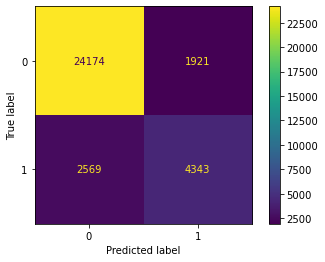

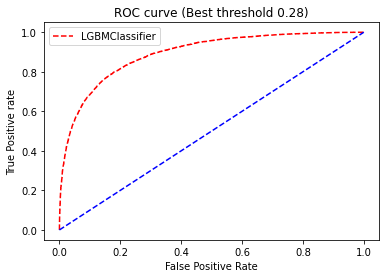

In [25]:
best_model,_ = train_a_model(x_over, y_over, x_val, y_val, best_model)
model_evaluation(best_model, x_val, y_val)

- Tune a model

In [ ]:
def tune_a_classifier(
    model: Literal["rf", "xgb", "lgbm"],
    x: np.ndarray,
    y: np.array,
    n_iter: int = 30,
    random_state: int = 123,
) -> object:
    def objective(trial):
        estimator = RandomForestClassifier()
        if model == "rf":
            param = {
                "n_estimators": trial.suggest_categorical(
                    "n_estimators", [20, 50, 100, 200, 300, 400, 600]
                ),
                "max_depth": trial.suggest_categorical(
                    "max_depth", [10, 20, 30, 40, 50, 60, 70, 80, 90]
                ),
                "min_samples_split": trial.suggest_categorical(
                    "min_samples_split", [2, 5, 10]
                ),
                "min_samples_leaf": trial.suggest_categorical(
                    "min_samples_leaf", [1, 2, 4]
                ),
                "random_state": trial.suggest_categorical("random_state", [random_state]),
                "class_weight": trial.suggest_categorical("class_weight", ["balanced"]),
            }
            estimator = RandomForestClassifier(**param)

        if model == "xgb":
            # xgb Parameters
            param = {
                "tree_method": "hist",
                "device": "cuda",
                #    'objective': trial.suggest_categorical('objective',['multi:softmax']),
                "objective": trial.suggest_categorical(
                    "objective", ["binary:logistic"]
                ),
                "eval_metric": trial.suggest_categorical("eval_metric", ["auc"]),
                "lambda": trial.suggest_float("lambda", 1e-3, 10.0, log=True),
                "alpha": trial.suggest_float("alpha", 1e-3, 10.0, log=True),
                "colsample_bytree": trial.suggest_categorical(
                    "colsample_bytree", [0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
                ),
                "subsample": trial.suggest_categorical(
                    "subsample", [0.4, 0.5, 0.6, 0.7, 0.8, 1.0]
                ),
                "learning_rate": trial.suggest_categorical(
                    "learning_rate",
                    [0.008, 0.009, 0.01, 0.012, 0.014, 0.016, 0.018, 0.02],
                ),
                "n_estimators": trial.suggest_categorical(
                    "n_estimators", [300, 400, 600, 800, 1000]
                ),
                "max_depth": trial.suggest_categorical(
                    "max_depth", [10, 20, 30, 40, 50, 60, 70, 80]
                ),
                "min_child_weight": trial.suggest_int("min_child_weight", 1, 300),
                #             'scale_pos_weight': trial.suggest_categorical('scale_pos_weight',[r, 1.2*r, 1.5*r , 2*r, 2.5*r]),
                #             'sample_weight': trial.suggest_categorical('sample_weight',[list(class_weight.values())]),
                #              'early_stopping_rounds': trial.suggest_categorical('early_stopping_rounds', [10]),
            }
            estimator = XGBClassifier(**param)
        if model == "lgbm":

            param = {
                "objective": trial.suggest_categorical("objective", ["binary"]),
                "metric": trial.suggest_categorical("metric", ["auc"]),
                "device": trial.suggest_categorical("device", ["gpu"]),
                "boosting": trial.suggest_categorical("boosting", ["goss"]),
                "learning_rate": trial.suggest_categorical(
                    "learning_rate",
                    [0.008, 0.009, 0.01, 0.012, 0.014, 0.016, 0.018, 0.02],
                ),
                "num_leaves": 8,
                "feature_fraction": trial.suggest_categorical(
                    "feature_fraction", [0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
                ),
                "bagging_fraction": trial.suggest_categorical(
                    "bagging_fraction", [0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
                ),
                "lambda_l1": trial.suggest_float("lambda_l1", 1e-3, 10.0, log=True),
                "lambda_l2": trial.suggest_float("lambda_l2", 1e-3, 10.0, log=True),
                "n_jobs": trial.suggest_categorical("n_jobs", [-1]),
                "is_unbalance": trial.suggest_categorical("is_unbalance", [True]),
                "verbose": trial.suggest_categorical("verbose", [-1]),
                "seed": trial.suggest_categorical("seed", [random_state]),
            }
            estimator = LGBMClassifier(**param)

        kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)
        res = []
        fold = 1
        for i_in, i_out in kfold.split(x_train, y_train):

            _, scores = train_a_model(
                x[i_in, :],
                y[i_in],
                x[i_out, :],
                y[i_out],
                estimator,
                verbos=False,
            )
            res.append(scores["AUC"])
            fold += 1

        return np.mean(res)
    
    study=optuna.create_study(direction='maximize')
    study.optimize(objective , n_trials=n_iter)
    print('Number of finished trials:', len(study.trials))
    print('Best trial:', study.best_trial.params)
    print(f"Best trial Score: {study.best_trial.value}")
    return study.best_trial.params



In [22]:
def tune_a_classifier(
    model: Literal["rf", "xgb", "lgbm"],
    x: np.ndarray,
    y: np.array,
    sample_size: int = 10000,
    random_search: bool = True,
    n_iter:int = 50,
    random_state: int = 123,
) -> [object, object]:
    """tune_a_model tunes an random forest or xgboost hyperparameters

    Parameters
    ----------
    model : str
        model type, can be one of ["rf", "xgb", "lgbm"]
    x : np.ndarray
        x data
    y : np.array
        y data
    sample_size : int, optional
        sample size, by default 1000
    random_search : bool, optional
        a toggle to switch random or grid search, by default True

    Returns
    -------
    [object, object]
        best_estimator and best_params
    """
    if model == "rf":
        grid = {
            "n_estimators": [20, 50, 100, 200, 300, 400, 600],
            "criterion": ["gini", "entropy"],
            "max_depth": [1, 5, 10, 25, 50, 75, 100],
            "min_samples_split": [2, 5, 10],
            "min_samples_leaf": [1, 2, 4],
            "random_state": [random_state],
            "max_features": ["auto", "sqrt", "log2"],
            "bootstrap": [True, False],
            "class_weight": [None, "balanced", "balanced_subsample"],
        }
        estimator = RandomForestClassifier(random_state=random_state)
    elif model == "xgb":
        grid = {
            "learning_rate": [0.008,0.009,0.01,0.012,0.014,0.016,0.018, 0.02],
            "n_estimators": [300, 400, 600, 800, 1000],
            "max_depth": [1, 5, 10, 25, 50, 75, 100],
            "min_child_weight": [1, 3, 5, 10, 100],
            "gamma": [0, 0.1, 0.2, 0.3],
            "subsample": [0.4,0.5,0.6,0.7,0.8,1.0],
            "colsample_bytree": [0.3,0.4,0.5,0.6,0.7,0.8,0.9, 1.0],
            'reg_alpha': [0.001, 0.01, 0.1, 1, 10], 
            'reg_lambda': [0.001, 0.01, 0.1, 1, 10],
            "scale_pos_weight": [1, 1.2, 1.5, 2, 2.5, 3],
            "objective": ["binary:logistic"],
            'random_state': [random_state],
            'tree_method':['hist'],
            }
        estimator = XGBClassifier(random_state=random_state)
    elif model == "lgbm":
        grid = {
        'random_state': [random_state],
        "n_estimators": [2000], 
        'objective': ['binary'], 
        'metric': ['auc'], 
        'learning_rate': [0.006,0.008,0.01,0.014,0.017,0.02],
        'feature_fraction': [0.3,0.4,0.5,0.6,0.7,0.8,0.9, 1.0],
        'bagging_fraction': [0.3,0.4,0.5,0.6,0.7,0.8,0.9, 1.0],
        'reg_alpha': [0.001, 0.01, 0.1, 1, 10], 
        'reg_lambda': [0.001, 0.01, 0.1, 1, 10],
        'num_leaves' : [3, 15, 31, 63, 127],
        'n_jobs': [-1],
        'is_unbalance':[True], 
        'colsample_bytree': [0.3,0.4,0.5,0.6,0.7,0.8,0.9, 1.0],
        'subsample': [0.4,0.5,0.6,0.7,0.8,1.0],
        'max_depth': [1, 10,20,100, -1],
        'min_child_samples': [20, 50, 100],
        'cat_smooth' : [1, 5, 50, 100],
        "min_split_gain": [0.0,0.1,0.2,0.3],
        "boosting_type": ["gbdt", "dart", "goss"],
        }
        estimator = LGBMClassifier(random_state=random_state)
    else:
        print("Please define the model you want to tune first!")

    kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)
    grid_search = GridSearchCV(
        estimator=estimator,
        param_grid=grid,
        scoring="roc_auc",
        n_jobs=-1,
        cv=kfold,
        verbose=-1,
    )
    if random_search:
        grid_search = RandomizedSearchCV(
            estimator=estimator,
            param_distributions=grid,
            n_iter=n_iter,
            cv=kfold,
            verbose=-1,
            scoring="roc_auc",
            random_state=random_state,
            n_jobs=-1,
        )

    if sample_size < x.shape[0]:
        sample_id = np.random.choice(x.shape[0], sample_size, replace=False)
        X_sample, y_sample = x[sample_id, :], y[sample_id]
    else:
        X_sample, y_sample = x, y

    grid_search.fit(X_sample, y_sample)
    print(grid_search.best_params_)
    return grid_search.best_estimator_, grid_search.best_params_

tune_a_classifier('lgbm', x_over, y_over, sample_size=x_over.shape[0], n_iter=30)

In [33]:
tuned_rf, rf_param = tune_a_classifier('rf', sample_x, sample_y)
tuned_lgb, lgb_param = tune_a_classifier('lgbm', sample_x, sample_y)
tuned_xgb, xgb_param = tune_a_classifier('xgb', sample_x, sample_y)

[LightGBM] [Warning] feature_fraction is set=0.3, colsample_bytree=0.9 will be ignored. Current value: feature_fraction=0.3
[LightGBM] [Warning] bagging_fraction is set=0.4, subsample=0.8 will be ignored. Current value: bagging_fraction=0.4
{'subsample': 0.8, 'reg_lambda': 10, 'reg_alpha': 0.1, 'random_state': 123, 'objective': 'binary', 'num_leaves': 15, 'n_jobs': -1, 'n_estimators': 2000, 'min_split_gain': 0.0, 'min_child_samples': 50, 'metric': 'auc', 'max_depth': 100, 'learning_rate': 0.008, 'is_unbalance': True, 'feature_fraction': 0.3, 'colsample_bytree': 0.9, 'cat_smooth': 1, 'boosting_type': 'gbdt', 'bagging_fraction': 0.4}
{'tree_method': 'hist', 'subsample': 0.8, 'scale_pos_weight': 2, 'reg_lambda': 10, 'reg_alpha': 1, 'random_state': 123, 'objective': 'binary:logistic', 'n_estimators': 1000, 'min_child_weight': 10, 'max_depth': 10, 'learning_rate': 0.02, 'gamma': 0.2, 'colsample_bytree': 0.4}


In [27]:

def tune_a_classifier(
    model: Literal["rf", "xgb", "lgbm"],
    x: np.ndarray,
    y: np.array,
    sample_size: int = 10000,
    random_search: bool = True,
    n_iter: int = 50,
    random_state: int = 123,
) -> [object, object]:
    """tune_a_model tunes an random forest or xgboost hyperparameters

    Parameters
    ----------
    model : str
        model type, can be one of ["rf", "xgb", "lgbm"]
    x : np.ndarray
        x data
    y : np.array
        y data
    sample_size : int, optional
        sample size, by default 1000
    random_search : bool, optional
        a toggle to switch random or grid search, by default True

    Returns
    -------
    [object, object]
        best_estimator and best_params
    """
    if model == "rf":
        grid = {
            "n_estimators": [20, 50, 100, 200, 300, 400, 600],
            "criterion": ["gini", "entropy"],
            "max_depth": [1, 5, 10, 25, 50, 75, 100],
            "min_samples_split": [2, 5, 10],
            "min_samples_leaf": [1, 2, 4],
            "random_state": [random_state],
            "max_features": ["auto", "sqrt", "log2"],
            "bootstrap": [True, False],
            "class_weight": [None, "balanced", "balanced_subsample"],
        }
        estimator = RandomForestClassifier(random_state=random_state)
    elif model == "xgb":
        grid = {
            "learning_rate": [0.008, 0.009, 0.01, 0.012, 0.014, 0.016, 0.018, 0.02],
            "n_estimators": [300, 400, 600, 800, 1000],
            "max_depth": [1, 5, 10, 25, 50, 75, 100],
            "min_child_weight": [1, 3, 5, 10, 100],
            "gamma": [0, 0.1, 0.2, 0.3],
            "subsample": [0.4, 0.5, 0.6, 0.7, 0.8, 1.0],
            "colsample_bytree": [0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
            "reg_alpha": [0.001, 0.01, 0.1, 1, 10],
            "reg_lambda": [0.001, 0.01, 0.1, 1, 10],
            "scale_pos_weight": [1, 1.2, 1.5, 2, 2.5, 3],
            "objective": ["binary:logistic"],
            "random_state": [random_state],
            "tree_method": ["hist"],
        }
        estimator = XGBClassifier(random_state=random_state)
    elif model == "lgbm":
        grid = {
            "random_state": [random_state],
            "n_estimators": [2000],
            "objective": ["binary"],
            "metric": ["auc"],
            "learning_rate": [0.006, 0.008, 0.01, 0.014, 0.017, 0.02],
            "feature_fraction": [0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
            "bagging_fraction": [0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
            "reg_alpha": [0.001, 0.01, 0.1, 1, 10],
            "reg_lambda": [0.001, 0.01, 0.1, 1, 10],
            "num_leaves": [3, 15, 31, 63, 127],
            "n_jobs": [-1],
            "is_unbalance": [True],
            "colsample_bytree": [0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
            "subsample": [0.4, 0.5, 0.6, 0.7, 0.8, 1.0],
            "max_depth": [1, 10, 20, 100, -1],
            "min_child_samples": [20, 50, 100],
            "cat_smooth": [1, 5, 50, 100],
            "min_split_gain": [0.0, 0.1, 0.2, 0.3],
            "boosting_type": ["gbdt", "dart", "goss"],
        }
        estimator = LGBMClassifier(random_state=random_state)
    else:
        print("Please define the model you want to tune first!")

    kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)
    grid_search = GridSearchCV(
        estimator=estimator,
        param_grid=grid,
        scoring="roc_auc",
        n_jobs=-1,
        cv=kfold,
        verbose=-1,
    )
    if random_search:
        grid_search = RandomizedSearchCV(
            estimator=estimator,
            param_distributions=grid,
            n_iter=n_iter,
            cv=kfold,
            verbose=-1,
            scoring="roc_auc",
            random_state=random_state,
            n_jobs=-1,
        )

    if sample_size < x.shape[0]:
        sample_id = np.random.choice(x.shape[0], sample_size, replace=False)
        X_sample, y_sample = x[sample_id, :], y[sample_id]
    else:
        X_sample, y_sample = x, y

    grid_search.fit(X_sample, y_sample)
    print(grid_search.best_params_)
    return grid_search.best_estimator_, grid_search.best_params_
tuned_lgb, lgb_param = tune_a_classifier('lgbm', sample_x, sample_y)


{'subsample': 0.8, 'reg_lambda': 10, 'reg_alpha': 0.1, 'random_state': 123, 'objective': 'binary', 'num_leaves': 15, 'n_jobs': -1, 'n_estimators': 2000, 'min_split_gain': 0.0, 'min_child_samples': 50, 'metric': 'auc', 'max_depth': 100, 'learning_rate': 0.008, 'is_unbalance': True, 'feature_fraction': 0.3, 'colsample_bytree': 0.9, 'cat_smooth': 1, 'boosting_type': 'gbdt', 'bagging_fraction': 0.4}


In [35]:
models = {
    "rf": RandomForestClassifier(**rf_param),
    "lgb": LGBMClassifier(**lgb_param),
    "xgb": XGBClassifier(**xgb_param),
}

best_model_2 = compare_models(sample_x, sample_y, models)

rf	Accuracy: 0.83	AUC: 0.83	Recall: 0.83	Precision: 0.83	F1-Score: 0.83	Kappa: 0.66	MCC: 0.66	Log Loss: 0.39	Training Time: 9.43	
[LightGBM] [Warning] feature_fraction is set=0.3, colsample_bytree=0.9 will be ignored. Current value: feature_fraction=0.3
[LightGBM] [Warning] bagging_fraction is set=0.4, subsample=0.8 will be ignored. Current value: bagging_fraction=0.4
[LightGBM] [Warning] feature_fraction is set=0.3, colsample_bytree=0.9 will be ignored. Current value: feature_fraction=0.3
[LightGBM] [Warning] bagging_fraction is set=0.4, subsample=0.8 will be ignored. Current value: bagging_fraction=0.4
[LightGBM] [Warning] feature_fraction is set=0.3, colsample_bytree=0.9 will be ignored. Current value: feature_fraction=0.3
[LightGBM] [Warning] bagging_fraction is set=0.4, subsample=0.8 will be ignored. Current value: bagging_fraction=0.4
[LightGBM] [Warning] feature_fraction is set=0.3, colsample_bytree=0.9 will be ignored. Current value: feature_fraction=0.3
[LightGBM] [Warning] ba

,Model,Accuracy,AUC,Recall,Precision,F1-Score,Kappa,MCC,Log Loss,Training Time
1,lgb,0.882669,0.882668,0.882669,0.883247,0.882624,0.765338,0.765916,0.282140,2.836835
2,xgb,0.863850,0.863845,0.863850,0.865812,0.863665,0.727697,0.729658,0.314075,5.341533
0,rf,0.831781,0.831780,0.831781,0.831880,0.831768,0.663561,0.663660,0.387607,9.432617


[LightGBM] [Warning] feature_fraction is set=0.3, colsample_bytree=0.9 will be ignored. Current value: feature_fraction=0.3
[LightGBM] [Warning] bagging_fraction is set=0.4, subsample=0.8 will be ignored. Current value: bagging_fraction=0.4

*******
Results for model LGBMClassifier(bagging_fraction=0.4, cat_smooth=1, colsample_bytree=0.9,
               feature_fraction=0.3, is_unbalance=True, learning_rate=0.008,
               max_depth=100, metric='auc', min_child_samples=50,
               n_estimators=2000, num_leaves=15, objective='binary',
               random_state=123, reg_alpha=0.1, reg_lambda=10, subsample=0.8):



,metrics,train,validation
0,Accuracy,0.91,0.86
1,AUC,0.91,0.77
2,Recall,0.91,0.86
3,Precision,0.91,0.86
4,F1-Score,0.91,0.86
5,Kappa,0.82,0.57
6,MCC,0.82,0.57
7,Log Loss,0.23,0.33
8,Training Time,32.02,32.02


              precision    recall  f1-score   support

           0       0.90      0.93      0.91     25959
           1       0.70      0.61      0.65      7048

    accuracy                           0.86     33007
   macro avg       0.80      0.77      0.78     33007
weighted avg       0.86      0.86      0.86     33007



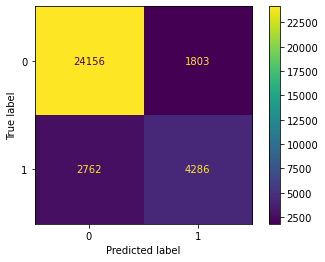

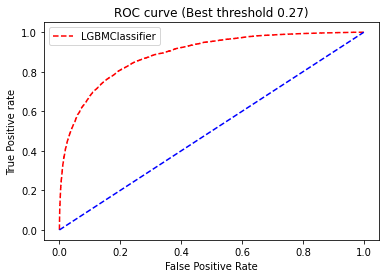

In [36]:
best_model_2,_ = train_a_model(x_over, y_over, x_val, y_val, best_model_2)
model_evaluation(best_model_2, x_val, y_val)


In [37]:
im_df = pd.DataFrame(
    {"feature": feature_copy, "score": best_model.feature_importances_}
).sort_values(by="score", ascending=False)

display(im_df.head(20))


,feature,score
8,Age,9476
9,Tenure,3488
6,CreditScore,2460
13,EstimatedSalary,2026
10,Balance,1721
50,1/Balance,1697
41,EstimatedSalary/Tenure,1600
30,tfid_11,1576
35,tfid_16,1552
22,tfid_3,1499


In [38]:
print p

SyntaxError: Missing parentheses in call to 'print'. Did you mean print(p)? (671083417.py, line 1)

- Ensembling


*******
Results for model VotingClassifier(estimators=[('rf',
                              RandomForestClassifier(bootstrap=False,
                                                     class_weight='balanced',
                                                     criterion='entropy',
                                                     max_depth=15,
                                                     max_features='log2',
                                                     n_estimators=50)),
                             ('gbc',
                              GradientBoostingClassifier(random_state=123)),
                             ('mlp', MLPClassifier(random_state=123))],
                 voting='soft'):



,metrics,train,validation
0,Accuracy,0.90,0.85
1,AUC,0.90,0.78
2,Recall,0.90,0.85
3,Precision,0.90,0.85
4,F1-Score,0.90,0.85
5,Kappa,0.80,0.56
6,MCC,0.80,0.56
7,Log Loss,0.27,0.35
8,Training Time,283.83,283.83


              precision    recall  f1-score   support

           0       0.91      0.91      0.91     38922
           1       0.65      0.66      0.65     10589

    accuracy                           0.85     49511
   macro avg       0.78      0.78      0.78     49511
weighted avg       0.85      0.85      0.85     49511



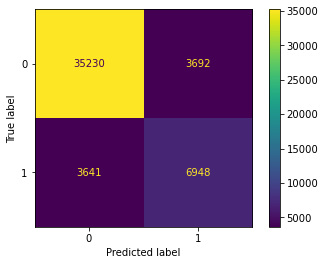

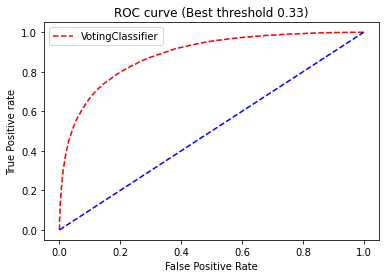

In [ ]:
ensemble = VotingClassifier(
            estimators=[('rf', RandomForestClassifier(**best_param)), 
                        ('gbc', models['gbc']),
                        ('mlp', models['mlp'])],
            voting="soft",
            weights=[0.8, 0.1, 0.1]
        )


ensemble_model2, _ = train_a_model(
    x_over,
    y_over,
    x_test,
    y_test,
    ensemble,
)
model_evaluation(ensemble_model2, x_test, y_test)

## Model Production

In [39]:
y_pred_test = best_model_2.predict_proba(x_test)[:,1]

pd.DataFrame({
    'id': test_id,
    'Exited':y_pred_test
}).to_csv('submission2.csv', index=False)